In [1]:
import numpy as np
import pandas as pd


/home/bfay/.pyenv/versions/temp_test/lib/python3.9/site-packages/pandas/compat/__init__.py:109: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
temp_df = pd.read_csv("data/Temperature Data.csv")
pop_df = pd.read_csv("data/Population Data.csv")

In [3]:
temp_df.head()

,name,country_name,country_code,continent,station_code,location_date,temp_mean_c,temp_min_c,temp_max_c
0,Atlanta,UnitedStates,USA,North America,KATL,4/20/2021,17.491667,12.2,23.3
1,Windsor Locks,UnitedStates,USA,North America,KBDL,4/20/2021,13.887500,3.9,22.2
2,Nashville,UnitedStates,USA,North America,KBNA,4/20/2021,15.175000,6.7,23.3
3,Boise,UnitedStates,USA,North America,KBOI,4/20/2021,9.329167,1.7,15.6
4,Boston,UnitedStates,USA,North America,KBOS,4/20/2021,16.716667,10.0,23.9


In [119]:
temp_df['join_key'] = 0
temp_df['join_key'].iloc[temp_df.station_code == 'KALB'] = -1 # ALBANY
temp_df['join_key'].iloc[temp_df.station_code == 'KPWM'] = -1  #  Portland, ME
temp_df['join_key'].iloc[temp_df.station_code == 'KRDU'] = 19 # (17) # Raleigh Durham
temp_df['join_key'].iloc[temp_df.station_code == 'KATL'] = 137  # ATLANTA
temp_df['join_key'].iloc[temp_df.station_code == 'KBDL'] = 263  # Hartford
temp_df['join_key'].iloc[temp_df.station_code == 'KBNA'] = 46  # Nashville 
temp_df['join_key'].iloc[temp_df.station_code == 'KBOI'] = 142  # Boise
temp_df['join_key'].iloc[temp_df.station_code == 'KBOS'] = 174  # Boston
temp_df['join_key'].iloc[temp_df.station_code == 'KBUF'] = 7  # Buffalo
temp_df['join_key'].iloc[temp_df.station_code == 'KBUR'] = 249  # Burbank
temp_df['join_key'].iloc[temp_df.station_code == 'KBWI'] = 169  # Baltimore
temp_df['join_key'].iloc[temp_df.station_code == 'KCMH'] = 25  # Columbus, OH 
temp_df['join_key'].iloc[temp_df.station_code == 'KCQT'] = 246  # Los Angeles
temp_df['join_key'].iloc[temp_df.station_code == 'KCVG'] = 22  # Cincinnati
temp_df['join_key'].iloc[temp_df.station_code == 'KDCA'] = 264  # DC (Reagan)
temp_df['join_key'].iloc[temp_df.station_code == 'KDEN'] = 129  # Denver
temp_df['join_key'].iloc[temp_df.station_code == 'KDFW'] = 70  # Dallars
temp_df['join_key'].iloc[temp_df.station_code == 'KDTW'] = 179  # Detroit 
temp_df['join_key'].iloc[temp_df.station_code == 'KFAT'] = 238  # Fresno
temp_df['join_key'].iloc[temp_df.station_code == 'KGEG'] = 96  # Spokane  
temp_df['join_key'].iloc[temp_df.station_code == 'KIAD'] = 264  #  DC (Dulles)
temp_df['join_key'].iloc[temp_df.station_code == 'KIAH'] = 76  # Houston
temp_df['join_key'].iloc[temp_df.station_code == 'KLAS'] = 195  # Las Vegas
temp_df['join_key'].iloc[temp_df.station_code == 'KLGA'] = 10  #  NYC (LaGuardia)
temp_df['join_key'].iloc[temp_df.station_code == 'KLIT'] = 215  #  Little Rock
temp_df['join_key'].iloc[temp_df.station_code == 'KMEM'] = 44  # Memphis
temp_df['join_key'].iloc[temp_df.station_code == 'KMSP'] = 182  # Minneapolis
temp_df['join_key'].iloc[temp_df.station_code == 'KMSY'] = 168  #  New Orleans
temp_df['join_key'].iloc[temp_df.station_code == 'KORD'] = 150  #  Chicago
temp_df['join_key'].iloc[temp_df.station_code == 'KPDX'] = 34  # Portland, OR
temp_df['join_key'].iloc[temp_df.station_code == 'KPHL'] = 39  # Philly
temp_df['join_key'].iloc[temp_df.station_code == 'KPHX'] = 108  # Phoenix
temp_df['join_key'].iloc[temp_df.station_code == 'KPIT'] = 37  #  Pittsburgh
temp_df['join_key'].iloc[temp_df.station_code == 'KRIC'] = 84  # Richmond, VA
temp_df['join_key'].iloc[temp_df.station_code == 'KSAC'] = 232  # Sacramento 
temp_df['join_key'].iloc[temp_df.station_code == 'KSEA'] = 92  # Seattle
temp_df['join_key'].iloc[temp_df.station_code == 'KSFO'] = 216  # San Francisco
temp_df['join_key'].iloc[temp_df.station_code == 'KSLC'] = 81  #  Salt Lake City
temp_df['join_key'].iloc[temp_df.station_code == 'KSTL'] = 190  #  St. Louis

/home/bfay/.pyenv/versions/temp_test/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [123]:
analysis_df = temp_df.merge(pop_df.reset_index(), left_on='join_key', right_on='index')

In [124]:
analysis_df.head()

,name,country_name,country_code,continent,station_code,location_date,temp_mean_c,temp_min_c,temp_max_c,join_key,index,City,State,population,Lon,Lat
0,Atlanta,UnitedStates,USA,North America,KATL,4/20/2021,17.491667,12.2,23.3,137,137,Atlanta,Georgia,432427,-84.4227,33.7629
1,Atlanta,UnitedStates,USA,North America,KATL,4/19/2021,16.154167,11.1,21.7,137,137,Atlanta,Georgia,432427,-84.4227,33.7629
2,Atlanta,UnitedStates,USA,North America,KATL,4/18/2021,16.720833,11.7,22.2,137,137,Atlanta,Georgia,432427,-84.4227,33.7629
3,Atlanta,UnitedStates,USA,North America,KATL,4/17/2021,16.795833,12.8,21.7,137,137,Atlanta,Georgia,432427,-84.4227,33.7629
4,Atlanta,UnitedStates,USA,North America,KATL,4/16/2021,14.695833,10.0,19.4,137,137,Atlanta,Georgia,432427,-84.4227,33.7629


In [125]:
analysis_df.pivot('location_date', columns=['station_code'], values=['temp_min_c', 'temp_max_c', 'temp_mean_c', 'population']).head()

temp_min_c                                                      \
station_code        KATL  KBDL  KBNA  KBOI  KBOS  KBUF KBUR  KBWI  KCMH KCQT   
location_date                                                                  
1/1/2015             0.0  -7.8  -5.0 -13.9  -5.6  -6.7 -0.6  -7.8  -7.2  3.3   
1/1/2016             3.9  -0.6   0.0 -15.0   0.6  -3.3  2.8  -0.6  -2.8  6.7   
1/1/2017             6.1  -3.9   7.8 -16.7   0.6  -2.2  3.9   2.2  -1.7  6.7   
1/1/2018            -7.8 -20.6 -13.9  -6.7 -17.8 -19.4  7.2 -15.0 -17.8  8.3   
1/1/2019            14.4   0.0   7.8  -9.4   1.1  -3.9  5.6   5.6   3.9  3.3   

               ... population                                          \
station_code   ...       KPHL      KPHX      KPIT      KRDU      KRIC   
location_date  ...                                                      
1/1/2015       ...  1536471.0  167721.0  307484.0  416468.0  144301.0   
1/1/2016       ...  1536471.0  167721.0  307484.0  416468.0  144301.0   
1/1/2017       ...  1536471.0  167721.0  307484.0  416468.0  144301.0   
1/1/2018       ...  1536471.0  167721.0  307484.0  416468.0  144301.0   
1/1/2019       ...  1536471.0  167721.0  307484.0  416468.0  144301.0   

                                                                 
station_code       KSAC      KSEA      KSFO      KSLC      KSTL  
location_date                                                    
1/1/2015       472178.0  620778.0  812826.0  189899.0  318069.0  
1/1/2016       472178.0  620778.0  812826.0  189899.0  318069.0  
1/1/2017       472178.0  620778.0  812826.0  189899.0  318069.0  
1/1/2018       472178.0  620778.0  812826.0  189899.0  318069.0  
1/1/2019       472178.0  620778.0  812826.0  189899.0  318069.0  

[5 rows x 148 columns]

In [129]:
analysis_df.location_date = pd.to_datetime(analysis_df.location_date)


In [139]:
reshaped_df = analysis_df.pivot('location_date', columns=['station_code'], values=['temp_min_c', 'temp_max_c', 'temp_mean_c', 'population'])
reshaped_df.describe()

temp_min_c                                                      \
station_code         KATL         KBDL         KBNA         KBOI         KBOS   
count         2287.000000  2288.000000  2288.000000  2288.000000  2288.000000   
mean            13.236205     5.514685    11.046766     6.178628     7.406206   
std              8.178563     9.919325     9.231099     8.293453     9.499317   
min            -11.700000   -23.900000   -15.600000   -22.800000   -22.800000   
25%              6.700000    -1.700000     3.900000     0.000000     0.150000   
50%             13.900000     5.000000    11.700000     5.600000     7.200000   
75%             21.100000    13.900000    20.000000    12.800000    16.100000   
max             26.100000    25.600000    26.100000    26.100000    28.300000   

                                                                               \
station_code         KBUF         KBUR         KBWI         KCMH         KCQT   
count         2286.000000  2287.000000  2286.000000  2287.000000  2287.000000   
mean             5.394619    13.223437     8.864917     7.404722    14.395802   
std             10.045231     4.894480     9.574573    10.037325     4.128017   
min            -24.400000    -0.600000   -17.200000   -23.300000     1.100000   
25%             -1.700000     9.400000     1.000000    -0.600000    11.100000   
50%              5.000000    13.300000     8.900000     7.200000    14.400000   
75%             14.400000    16.700000    17.800000    16.700000    17.200000   
max             24.400000    28.300000    26.700000    25.000000    26.100000   

              ... population                                          \
station_code  ...       KPHL      KPHX      KPIT      KRDU      KRIC   
count         ...     2288.0    2302.0    2288.0    2288.0    2288.0   
mean          ...  1536471.0  167721.0  307484.0  416468.0  144301.0   
std           ...        0.0       0.0       0.0       0.0       0.0   
min           ...  1536471.0  167721.0  307484.0  416468.0  144301.0   
25%           ...  1536471.0  167721.0  307484.0  416468.0  144301.0   
50%           ...  1536471.0  167721.0  307484.0  416468.0  144301.0   
75%           ...  1536471.0  167721.0  307484.0  416468.0  144301.0   
max           ...  1536471.0  167721.0  307484.0  416468.0  144301.0   

                                                                
station_code      KSAC      KSEA      KSFO      KSLC      KSTL  
count           2288.0    2288.0    2287.0    2287.0    2288.0  
mean          472178.0  620778.0  812826.0  189899.0  318069.0  
std                0.0       0.0       0.0       0.0       0.0  
min           472178.0  620778.0  812826.0  189899.0  318069.0  
25%           472178.0  620778.0  812826.0  189899.0  318069.0  
50%           472178.0  620778.0  812826.0  189899.0  318069.0  
75%           472178.0  620778.0  812826.0  189899.0  318069.0  
max           472178.0  620778.0  812826.0  189899.0  318069.0  

[8 rows x 148 columns]

In [137]:
reshaped_df.columns = reshaped_df.columns.to_series().str.join('_')

In [140]:
reshaped_df.head()

temp_min_c                                                   \
station_code        KATL KBDL KBNA  KBOI KBOS  KBUF KBUR KBWI  KCMH  KCQT   
location_date                                                               
2015-01-01           0.0 -7.8 -5.0 -13.9 -5.6  -6.7 -0.6 -7.8  -7.2   3.3   
2015-01-02           6.7 -3.3  3.3 -13.3 -0.6  -5.0  0.6 -2.2  -3.9   3.9   
2015-01-03           8.9 -5.0  6.7 -10.6 -5.0  -5.6  2.8 -2.8  -1.1   4.4   
2015-01-04           6.7 -1.1 -2.2  -6.1  2.2  -2.2  3.3  3.9  -2.8   6.1   
2015-01-05           1.1 -9.4 -6.1  -1.7 -8.3 -12.8  6.7 -4.4 -11.0  10.6   

               ... population                                          \
station_code   ...       KPHL      KPHX      KPIT      KRDU      KRIC   
location_date  ...                                                      
2015-01-01     ...  1536471.0  167721.0  307484.0  416468.0  144301.0   
2015-01-02     ...  1536471.0  167721.0  307484.0  416468.0  144301.0   
2015-01-03     ...  1536471.0  167721.0  307484.0  416468.0  144301.0   
2015-01-04     ...  1536471.0  167721.0  307484.0  416468.0  144301.0   
2015-01-05     ...  1536471.0  167721.0  307484.0  416468.0  144301.0   

                                                                 
station_code       KSAC      KSEA      KSFO      KSLC      KSTL  
location_date                                                    
2015-01-01     472178.0  620778.0  812826.0  189899.0  318069.0  
2015-01-02     472178.0  620778.0  812826.0  189899.0  318069.0  
2015-01-03     472178.0  620778.0  812826.0  189899.0  318069.0  
2015-01-04     472178.0  620778.0  812826.0  189899.0  318069.0  
2015-01-05     472178.0  620778.0  812826.0  189899.0  318069.0  

[5 rows x 148 columns]

In [143]:
interpolated_df = reshaped_df.interpolate('time', axis=0,)
# Add flag to missing values

In [ ]:
analysis_df.pivot('location_date', columns=['station_code'], values=['temp_min_c', 'temp_max_c', 'temp_mean_c', 'population'])

In [190]:
interpolated_df.head()

temp_min_c                                                   \
station_code        KATL KBDL KBNA  KBOI KBOS  KBUF KBUR KBWI  KCMH  KCQT   
location_date                                                               
2015-01-01           0.0 -7.8 -5.0 -13.9 -5.6  -6.7 -0.6 -7.8  -7.2   3.3   
2015-01-02           6.7 -3.3  3.3 -13.3 -0.6  -5.0  0.6 -2.2  -3.9   3.9   
2015-01-03           8.9 -5.0  6.7 -10.6 -5.0  -5.6  2.8 -2.8  -1.1   4.4   
2015-01-04           6.7 -1.1 -2.2  -6.1  2.2  -2.2  3.3  3.9  -2.8   6.1   
2015-01-05           1.1 -9.4 -6.1  -1.7 -8.3 -12.8  6.7 -4.4 -11.0  10.6   

               ... population                                          \
station_code   ...       KPHL      KPHX      KPIT      KRDU      KRIC   
location_date  ...                                                      
2015-01-01     ...  1536471.0  167721.0  307484.0  416468.0  144301.0   
2015-01-02     ...  1536471.0  167721.0  307484.0  416468.0  144301.0   
2015-01-03     ...  1536471.0  167721.0  307484.0  416468.0  144301.0   
2015-01-04     ...  1536471.0  167721.0  307484.0  416468.0  144301.0   
2015-01-05     ...  1536471.0  167721.0  307484.0  416468.0  144301.0   

                                                                 
station_code       KSAC      KSEA      KSFO      KSLC      KSTL  
location_date                                                    
2015-01-01     472178.0  620778.0  812826.0  189899.0  318069.0  
2015-01-02     472178.0  620778.0  812826.0  189899.0  318069.0  
2015-01-03     472178.0  620778.0  812826.0  189899.0  318069.0  
2015-01-04     472178.0  620778.0  812826.0  189899.0  318069.0  
2015-01-05     472178.0  620778.0  812826.0  189899.0  318069.0  

[5 rows x 148 columns]

In [219]:
melted_df = interpolated_df.melt(
    ignore_index=False
)

In [220]:
melted_df.columns = ['metric', 'station_code', 'value']

In [225]:
final_df = melted_df.reset_index().pivot(['location_date', 'station_code'], columns='metric', values='value')

In [233]:
final_df['weight'] = final_df.population.div(final_df.reset_index(level=1).groupby('location_date').population.sum())

In [234]:
final_df.head()

metric                      population  temp_max_c  temp_mean_c  temp_min_c  \
location_date station_code                                                    
2015-01-01    KATL            432427.0        13.9     6.758333         0.0   
              KBDL            124867.0         1.1    -1.991667        -7.8   
              KBNA            609644.0         5.0     1.141667        -5.0   
              KBOI            210145.0        -8.0   -11.070833       -13.9   
              KBOS            625087.0         0.6    -2.329167        -5.6   

metric                        weight  
location_date station_code            
2015-01-01    KATL          0.013002  
              KBDL          0.003754  
              KBNA          0.018330  
              KBOI          0.006318  
              KBOS          0.018794

In [235]:
final_df['weighted_temp_min'] = final_df.temp_min_c.mul(final_df.weight)
final_df['weighted_temp_max'] = final_df.temp_max_c.mul(final_df.weight)
final_df['weighted_temp_mean'] = final_df.temp_mean_c.mul(final_df.weight)

In [236]:
final_df.head()

metric                      population  temp_max_c  temp_mean_c  temp_min_c  \
location_date station_code                                                    
2015-01-01    KATL            432427.0        13.9     6.758333         0.0   
              KBDL            124867.0         1.1    -1.991667        -7.8   
              KBNA            609644.0         5.0     1.141667        -5.0   
              KBOI            210145.0        -8.0   -11.070833       -13.9   
              KBOS            625087.0         0.6    -2.329167        -5.6   

metric                        weight  weighted_temp_min  weighted_temp_max  \
location_date station_code                                                   
2015-01-01    KATL          0.013002           0.000000           0.180721   
              KBDL          0.003754          -0.029284           0.004130   
              KBNA          0.018330          -0.091649           0.091649   
              KBOI          0.006318          -0.087824          -0.050546   
              KBOS          0.018794          -0.105247           0.011276   

metric                      weighted_temp_mean  
location_date station_code                      
2015-01-01    KATL                    0.087869  
              KBDL                   -0.007477  
              KBNA                    0.020927  
              KBOI                   -0.069949  
              KBOS                   -0.043775

In [239]:
plotting_df = final_df.groupby('location_date').agg(
    {
        'weighted_temp_min': np.sum,
        'weighted_temp_max': np.sum,
        'weighted_temp_mean': np.sum
    }
)

<AxesSubplot:xlabel='location_date'>

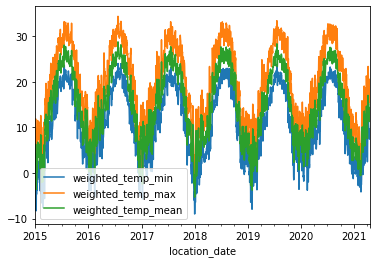

In [242]:
%matplotlib inline
plotting_df.plot()

In [243]:
import altair as alt

In [247]:
alt.Chart(plotting_df.reset_index()).mark_line().encode(
    x='location_date', 
    y='weighted_temp_mean'
)

alt.Chart(...)